https://www.kaggle.com/hmendonca/u-net-model-with-submission

# Attribution


1. slight deviation from previous Unet model.   
2. IOI loss function 적용  

In [1]:
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize


from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.regularizers import l2

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.3.1
2.0.0


In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17280736507001499327
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13123309763902610435
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15043936909040769838
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16612939638936352287
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11992616141
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16124335190086466807
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:0b:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memor

In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"
from keras import models, layers

masks = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

print(masks.shape[0],'masks found')

masks.head()

231723 masks found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

# Overview
We try here to improve another public U-Net model: https://www.kaggle.com/kmader/baseline-u-net-model-part-1 which shows how to extract the segmentation map for the ships, augment the images and train a simple DNN model to detect them. A few additional tweaks like balancing the ship-count out a little better have also been done.

We are using a different loss function (closer to the competition scoring) and also fix and improve some visualisation functions and the submission itself.

Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [7]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [8]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [9]:
masks = pd.read_csv(os.path.join(path , 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Make sure encode/decode works
Given the process
$$
RLE0⟶DecodeImage0⟶EncodeRLE1⟶DecodeImage1
 $$
We want to check if/that  Image0=?Image1  We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


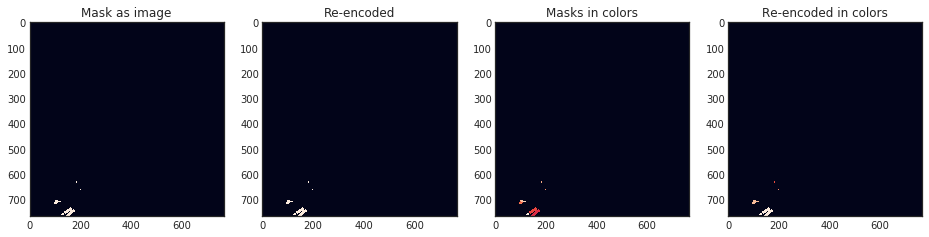

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
21708,1cde4f8f1.jpg,0,0.0,[0.0],184.825195
117137,9bb6a74c8.jpg,1,1.0,[1.0],114.142578
144590,c04527907.jpg,0,0.0,[0.0],139.687500
124732,a5ead7e0f.jpg,0,0.0,[0.0],127.115234
11915,0fc452c0c.jpg,0,0.0,[0.0],116.065430
176256,ea6d85112.jpg,0,0.0,[0.0],204.121094
137491,b6b95ecd2.jpg,0,0.0,[0.0],162.614258


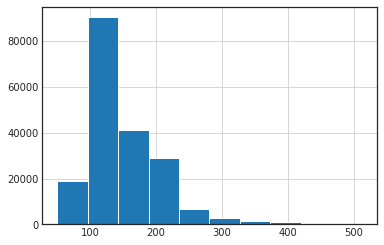

In [11]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

# Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

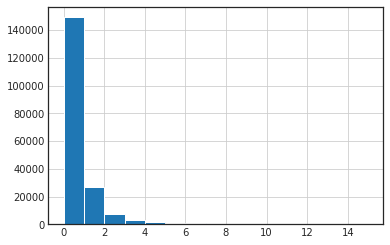

In [12]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

In [13]:
#SAMPLES_PER_GROUP = 2000
#balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
#balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
#print(balanced_train_df.shape[0], 'masks')

12788 masks


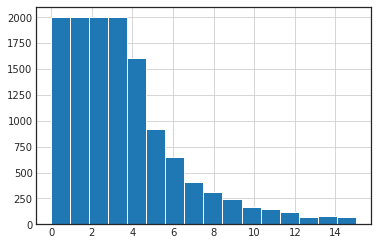

In [17]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [18]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


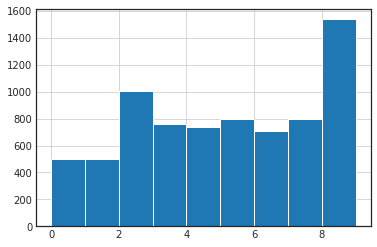

In [19]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [20]:
train_df

,ImageId,EncodedPixels,ships,has_ship,has_ship_vec,file_size_kb,grouped_ship_count
0,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5,1.0,[1.0],75.221680,3
1,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5,1.0,[1.0],75.221680,3
2,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5,1.0,[1.0],75.221680,3
3,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5,1.0,[1.0],75.221680,3
4,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,5,1.0,[1.0],75.221680,3
...,...,...,...,...,...,...,...
35359,ffe2fcd0e.jpg,140499 1 141266 3 142033 5 142800 7 143566 9 1...,4,1.0,[1.0],147.257812,2
35360,ffe7ab0c7.jpg,NaN,0,0.0,[0.0],189.625977,0
35361,ffea9a5ba.jpg,528031 6 528788 17 529550 23 530318 23 531086 ...,3,1.0,[1.0],152.047852,2
35362,ffea9a5ba.jpg,26797 1 27564 4 28332 5 29099 5 29866 5 30635 ...,3,1.0,[1.0],152.047852,2


In [21]:
balanced_train_df

ImageId  \
grouped_ship_count                        
0                  15855  721cb1fb1.jpg   
                   22006  9edaf3c10.jpg   
                   34268  f7c960fb5.jpg   
                   10854  4f50a3781.jpg   
                   3560   1afb447db.jpg   
...                                 ...   
7                  10074  4a4a6ccd2.jpg   
                   28217  cc8960db1.jpg   
                   24237  af6d7e762.jpg   
                   13636  626beb313.jpg   
                   17636  7ed6fd5e5.jpg   

                                                              EncodedPixels  \
grouped_ship_count                                                            
0                  15855                                                NaN   
                   22006                                                NaN   
                   34268                                                NaN   
                   10854                                                NaN   
                   3560                                                 NaN   
...                                                                     ...   
7                  10074  277331 3 278098 9 278866 15 279634 20 280402 2...   
                   28217  280627 2 281394 4 282161 4 282928 4 283695 5 2...   
                   24237  322010 3 322778 3 323546 3 324313 4 325081 4 3...   
                   13636   144422 11 145190 11 145958 11 146726 11 147494 5   
                   17636       322921 1 323688 3 324455 5 325224 4 325994 1   

                          ships  has_ship has_ship_vec  file_size_kb  \
grouped_ship_count                                                     
0                  15855      0       0.0        [0.0]    195.018555   
                   22006      0       0.0        [0.0]    107.773438   
                   34268      0       0.0        [0.0]     89.324219   
                   10854      0       0.0        [0.0]    240.445312   
                   3560       0       0.0        [0.0]     97.277344   
...                         ...       ...          ...           ...   
7                  10074     15       1.0        [1.0]    115.333984   
                   28217     15       1.0        [1.0]    124.710938   
                   24237     13       1.0        [1.0]    142.980469   
                   13636     15       1.0        [1.0]    170.021484   
                   17636     15       1.0        [1.0]    146.528320   

                          grouped_ship_count  
grouped_ship_count                            
0                  15855                   0  
                   22006                   0  
                   34268                   0  
                   10854                   0  
                   3560                    0  
...                                      ...  
7                  10074                   7  
                   28217                   7  
                   24237                   7  
                   13636                   7  
                   17636                   7  

[11000 rows x 7 columns]

In [22]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

8800 training masks
2200 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [23]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            #print('c_masks->',c_masks)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [24]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montag

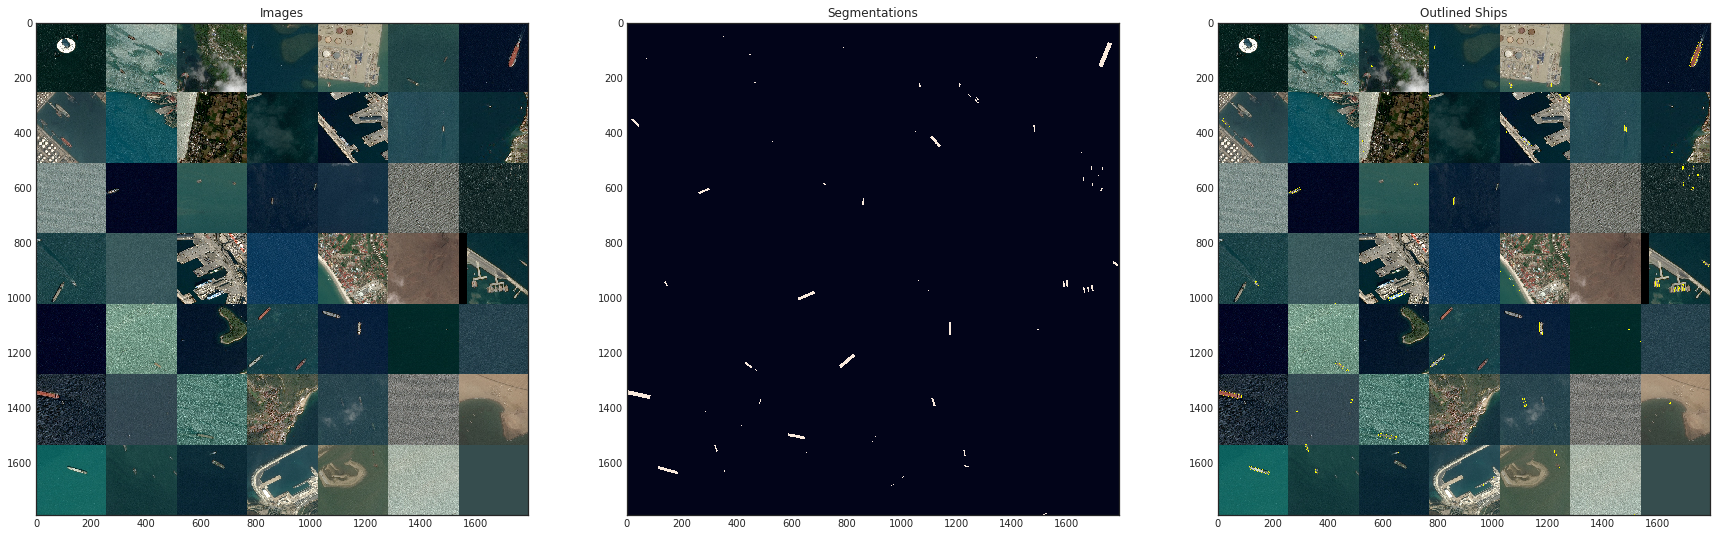

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Make the Validation Set¶


In [26]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 9.93 s, sys: 759 ms, total: 10.7 s
Wall time: 19 s


# Augment Data¶


In [27]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/jake/venv/lib/python3.7/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montag

Text(0.5, 1.0, 'ships')

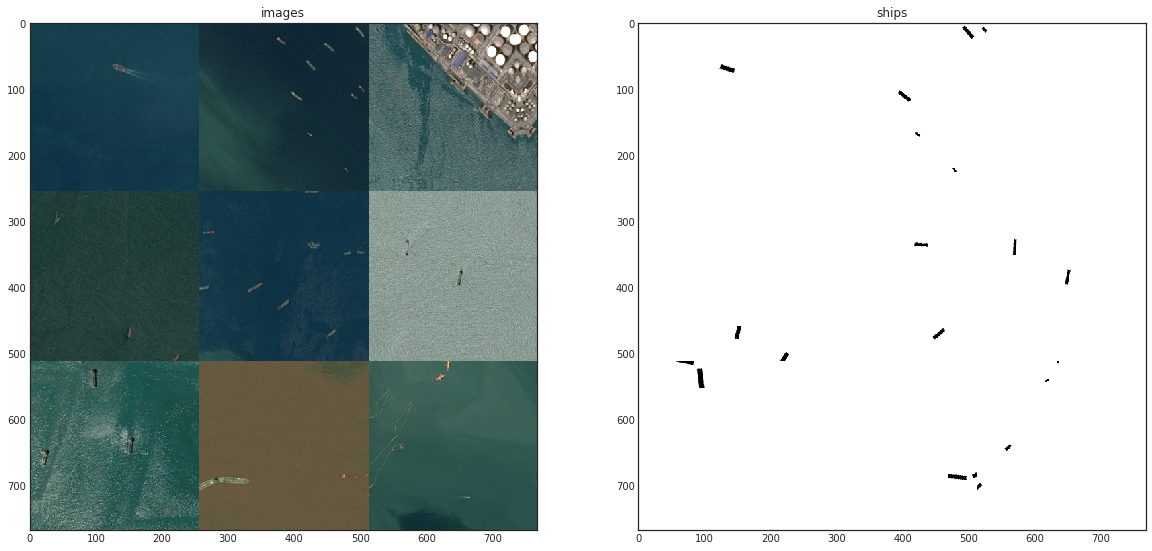

In [28]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [29]:
gc.collect()

47

# build Model 2

##### create upsampling layers

In [30]:
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate

def handle_block_names_decode(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [31]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output
    print(x)
    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        if i < len(skip_layers):
            print(backbone.layers[skip_layers[i]])
            print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

##### Built ResNet34 model
#################### Reference this github

In [32]:
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Add
from keras.layers import ZeroPadding2D

def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def conv_block(filters, stage, block, strides=(2, 2)):
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def identity_block(filters, stage, block):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [33]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [34]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from keras.engine import get_source_inputs

import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape
    
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

## Load pretrain Weight by using ImageNet trained
Reference this GITHUB

In [35]:
from keras.utils import get_file


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))
        
        
        

In [36]:
weights_collection = [

    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    }]

### Buil Unet model base on ResNet34¶


In [37]:
#Freeze Encoder weight if needed
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

In [38]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = build_resnet(input_tensor=None,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=False,
                         block_type='basic')
    backbone.name = 'resnet34'
    
    if encoder_weights == True:
        load_model_weights(weights_collection, backbone , dataset= 'imagenet', classes = 1, include_top=False)
    
    skip_connections = list([129, 74, 37, 5]) # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'
    
    #freeze_model(backbone)

    return model

In [39]:
seg_model = UResNet34(input_shape=(256,256,3),encoder_weights=True)

Tensor("relu1/Relu:0", shape=(None, 8, 8, 512), dtype=float32)
Tensor("stage4_unit1_relu1/Relu:0", shape=(None, 16, 16, 256), dtype=float32)
Tensor("stage3_unit1_relu1/Relu:0", shape=(None, 32, 32, 128), dtype=float32)
Tensor("stage2_unit1_relu1/Relu:0", shape=(None, 64, 64, 64), dtype=float32)
Tensor("relu0/Relu:0", shape=(None, 128, 128, 64), dtype=float32)


In [40]:
#seg_model_origin.summary()

In [41]:
seg_model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

### define Loss function

In [42]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [43]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [44]:
gc.collect()

387

# set training check point

In [45]:
weight_path = path + 'models/seg_model_Unet34.h5'

In [46]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path=path + "/models/{}_weights.best.hdf5".format('seg_model_Unet34')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [47]:
# Comiple model
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=bce_logdice_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

# Unet34 train

In [48]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    #print(y_true)
    #if np.max(y_true) == 0.0:
    #    return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [49]:
seg_model.summary()

Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

In [50]:
gc.collect()

66

In [65]:
'''
epochs = 100
batch_size = 32

step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen,
                            steps_per_epoch=step_count,
                            validation_data=(valid_x, valid_y), 
                            epochs=5,
                            callbacks=callbacks_list,shuffle=True)]
                            '''

'\nepochs = 100\nbatch_size = 32\n\nstep_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)\naug_gen = create_aug_gen(make_image_gen(balanced_train_df))\nloss_history = [seg_model.fit_generator(aug_gen,\n                            steps_per_epoch=step_count,\n                            validation_data=(valid_x, valid_y), \n                            epochs=5,\n                            callbacks=callbacks_list,shuffle=True)]\n                            '

In [ ]:

def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history
i = 0

while True:
    if i==1: break
    i+=1
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break
        

Epoch 1/99
9/9 [==============================] - 21s 2s/step - loss: -0.0499 - binary_accuracy: 0.9929 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 2/99


/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_dice_coef available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_dice_coef` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


9/9 [==============================] - 7s 817ms/step - loss: -0.1458 - binary_accuracy: 0.9970 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 3/99


/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_dice_coef` which is not available. Available metrics are: val_loss,val_binary_accuracy,loss,binary_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


9/9 [==============================] - 15s 2s/step - loss: -0.1343 - binary_accuracy: 0.9966 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 4/99
9/9 [==============================] - 17s 2s/step - loss: -0.1250 - binary_accuracy: 0.9964 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 5/99
9/9 [==============================] - 15s 2s/step - loss: -0.1273 - binary_accuracy: 0.9965 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 6/99
9/9 [==============================] - 15s 2s/step - loss: -0.1366 - binary_accuracy: 0.9961 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 7/99
9/9 [==============================] - 15s 2s/step - loss: -0.1065 - binary_accuracy: 0.9968 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 8/99
9/9 [==============================] - 15s 2s/step - loss: -0.1181 - binary_accuracy: 0.9960 - val_loss: -0.0656 - val_binary_accuracy: 0.9983
Epoch 9/99
9/9 [==============================] - 15s 2s/step - loss: -0.1551 - binary_

In [52]:
weight_path

'/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/models/seg_model_Unet34.h5'

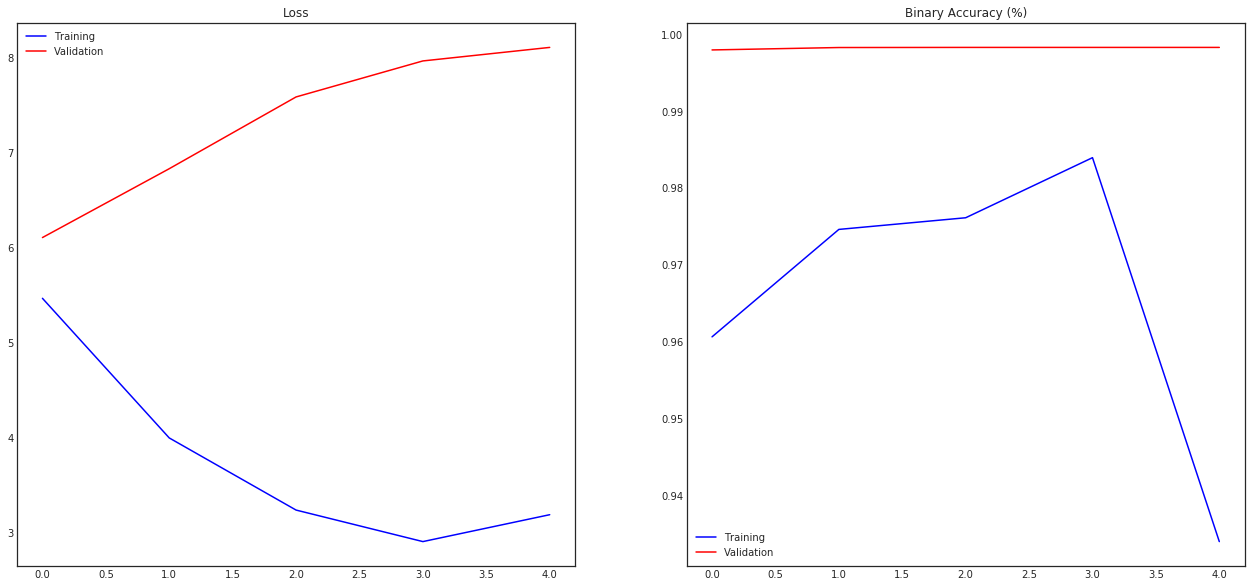

In [53]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [54]:
seg_model.load_weights(weight_path)
seg_model.save(weight_path)

In [55]:
seg_model.load_weights(weight_path)
seg_model.save(path + '/models/seg_model_Unet34.h5')

In [56]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 0.46586698 0.0 0.0010819859


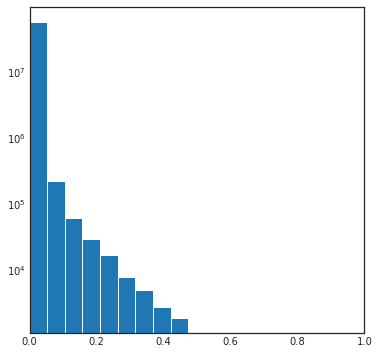

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [ ]:
'''
if IMG_SCALING is not None:
    fullres_model_origin = models.Sequential()
    fullres_model_origin.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model_origin.add(seg_model_origin)
    fullres_model_origin.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model_origin = seg_model_origin
fullres_model_origin.save(path + '/models/seg_model_Unet34.h5')
fullres_model_origin.summary()
'''

In [58]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save(path + '/models/seg_model_Unet34_fullness.h5')
fullres_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, None, None, 3)     0         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24453178  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 1)     0         
Total params: 24,453,178
Trainable params: 24,437,812
Non-trainable params: 15,366
_________________________________________________________________


# Visualize predictions¶

In [61]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


InvalidArgumentError:  Size 1 must be non-negative, not -21
	 [[{{node u-resnet34/bn_data/batchnorm/mul-1-ReshapeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_keras_scratch_graph_49814]

Function call stack:
keras_scratch_graph


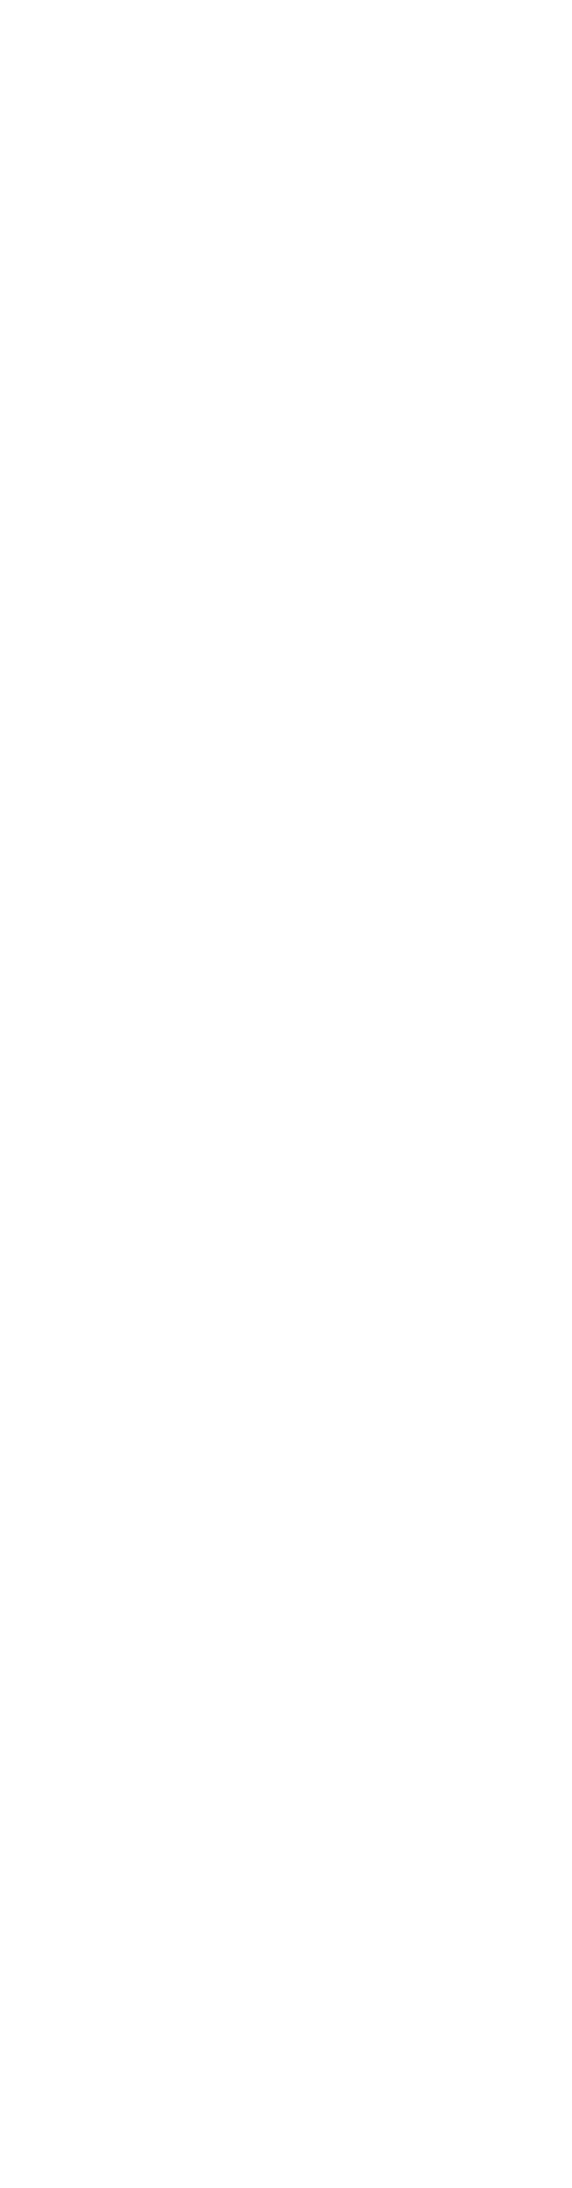

In [62]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0,:, :, 0])
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

# submission

In [ ]:
have_ship= pd.read_csv("Have_ship_or_not.csv")

In [ ]:
test_names = have_ship.loc[have_ship['Have_ship'] > 0.5, ['ImageId']]['ImageId'].values.tolist()
test_names_nothing = have_ship.loc[have_ship['Have_ship'] <= 0.5, ['ImageId']]['ImageId'].values.tolist()
len(test_names), len(test_names_nothing)

In [ ]:
ship_list_dict = []
for name in test_names_nothing:
    ship_list_dict.append({'ImageId':name,'EncodedPixels':None})

In [ ]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

In [ ]:
%%time
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
for c_img_name in tqdm_notebook(test_paths):
    if c_img_name in test_names:
        c_path = os.path.join(test_image_dir, c_img_name)
        c_img = imread(c_path)
        c_img = np.expand_dims(c_img, 0)/255.0
        cur_seg = fullres_model.predict(c_img)[0]
        cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
        cur_rles = multi_rle_encode(cur_seg)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                ship_list_dict += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
        else:
            ship_list_dict += [{'ImageId': c_img_name, 'EncodedPixels': 'None'}]
    gc.collect()

In [ ]:
submission_df = pd.DataFrame(ship_list_dict)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

In [ ]:
submission_df.loc[submission_df['EncodedPixels'] != None]

# Submission

In [63]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


In [64]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

/home/jake/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


InvalidArgumentError:  Size 1 must be non-negative, not -21
	 [[{{node u-resnet34/bn_data/batchnorm/mul-1-ReshapeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_keras_scratch_graph_49814]

Function call stack:
keras_scratch_graph


In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

In [ ]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [ ]:
sub1 = pd.read_csv(path + '/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission_02.csv', index=False)
sub.head()


In [ ]:
sub